# Import ACLED Data
We use the [Data Export Tool](https://acleddata.com/data-export-tool/) to get the data.

In [1]:
import os
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
acled = pd.read_csv("../../../../Data/ACLED Colombia (2018-01-01-2023-10-31).csv", sep = ";")

## Exploración de la base de datos

In [3]:
# Inspeccionemos las columnas disponibles
acled.columns

Index(['event_id_cnty', 'event_date', 'year', 'time_precision',
       'disorder_type', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'interaction', 'civilian_targeting', 'iso',
       'region', 'country', 'admin1', 'admin2', 'admin3', 'location',
       'latitude', 'longitude', 'geo_precision', 'source', 'source_scale',
       'notes', 'fatalities', 'tags', 'timestamp'],
      dtype='object')

In [4]:
# Arreglamos los formatos de fecha
acled["timestamp"] = acled["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x))
acled["event_date"] = pd.to_datetime(acled["event_date"])

In [5]:
# Tenemos eventos desde el enero del 2018
print("Fecha mínima", acled["event_date"].min().strftime("%Y-%m-%d"))
print("Fecha máxima", acled["event_date"].max().strftime("%Y-%m-%d"))

Fecha mínima 2018-01-01
Fecha máxima 2023-10-31


In [6]:
# Entendamos que variables tenemos
acled["disorder_type"].value_counts(normalize = True)

disorder_type
Political violence                    0.651066
Demonstrations                        0.237154
Strategic developments                0.108382
Political violence; Demonstrations    0.003398
Name: proportion, dtype: float64

In [7]:
acled["event_type"].value_counts(normalize = True)

event_type
Violence against civilians    0.373494
Protests                      0.193080
Battles                       0.182371
Strategic developments        0.108382
Riots                         0.087607
Explosions/Remote violence    0.055066
Name: proportion, dtype: float64

In [8]:
acled["sub_event_type"].value_counts(normalize = True)

sub_event_type
Attack                                0.331222
Armed clash                           0.182371
Peaceful protest                      0.180157
Violent demonstration                 0.047472
Mob violence                          0.040135
Abduction/forced disappearance        0.039852
Remote explosive/landmine/IED         0.037998
Looting/property destruction          0.037071
Disrupted weapons use                 0.034368
Other                                 0.025409
Grenade                               0.015215
Protest with intervention             0.009525
Change to group/activity              0.007002
Arrests                               0.004068
Excessive force against protesters    0.003398
Sexual violence                       0.002420
Air/drone strike                      0.001545
Agreement                             0.000412
Shelling/artillery/missile attack     0.000206
Suicide bomb                          0.000103
Headquarters or base established      0.00002

In [9]:
acled["actor1"].value_counts(normalize = True)

actor1
Civilians (Colombia)                                                                                                        0.231619
Unidentified Armed Group (Colombia)                                                                                         0.221450
Protesters (Colombia)                                                                                                       0.185846
Military Forces of Colombia (2018-2022)                                                                                     0.053496
Rioters (Colombia)                                                                                                          0.051128
                                                                                                                              ...   
FARC Dissident - 19th Front: Revolutionary Armed Forces of Colombia Dissident Faction (19th Front)                          0.000026
FARC Dissident - Dario Gutierrez Front: Revolutionary Armed Fo

In [10]:
acled["assoc_actor_1"].value_counts(normalize = True)

assoc_actor_1
Labor Group (Colombia)                                                                                                                                                                                                   0.154125
CNP: National Strike Committee                                                                                                                                                                                           0.089052
Farmers (Colombia)                                                                                                                                                                                                       0.066230
Students (Colombia)                                                                                                                                                                                                      0.050887
Women (Colombia)                                                                  

**What are interaction codes?**

All actors in ACLED are categorized by actor type, and each type is associated with an Inter code ranging from 1-8. The combination of the two Inter codes (for Actor1 and Actor2) are joined to generate Interactions that represent engagements between specific types of actors. There are many set interactions that can be used to immediately correspond to a specific type of engagement. For example, an interaction code of 12 indicates that state forces interacted with a rebel group. For more information on actors and interaction codes, see the [ACLED Codebook](https://acleddata.com/acleddatanew/wp-content/uploads/dlm_uploads/2023/06/ACLED_Codebook_2023.pdf).

In [11]:
inter_code_dict = {1: "State Forces", 2: "Rebel Groups", 3: "Political Militias", 4: "Identity Militias", 
                   5: "Rioters", 6: "Protesters", 7: "Civilians", 8: "External/Other Force"}

In [12]:
acled['inter1'] = acled['inter1'].map(inter_code_dict)
acled['inter1'].value_counts(normalize = True)

inter1
Political Militias      0.270569
Civilians               0.238518
Protesters              0.186644
State Forces            0.138477
Rebel Groups            0.110751
Rioters                 0.051308
External/Other Force    0.001879
Identity Militias       0.001854
Name: proportion, dtype: float64

In [13]:
interaction_code_dict = {10: "SOLE STATE FORCES ACTION", 11: "STATE FORCES VERSUS STATE FORCES", 12: "STATE FORCES VERSUS REBELS",
                         13: "STATE FORCES VERSUS POLITICAL MILITIA", 14: "STATE FORCES VERSUS IDENTITY MILITIA", 
                         15: "STATE FORCES VERSUS RIOTERS", 16: "STATE FORCES VERSUS PROTESTERS", 17: "STATE FORCES VERSUS CIVILIANS",
                         18: "STATE FORCES VERSUS EXTERNAL/OTHER FORCES", 20: "SOLE REBEL ACTION",
                         22: "REBELS VERSUS REBELS", 23: "REBELS VERSUS POLITICAL MILITIA", 24: "REBELS VERSUS IDENTITY MILITIA",
                         25: "REBELS VERSUS RIOTERS", 26: "REBELS VERSUS PROTESTERS", 27: "REBELS VERSUS CIVILIANS", 28: "REBELS VERSUS OTHERS",
                         30: "SOLE POLITICAL MILITIA ACTION", 33: "POLITICAL MILITIA VERSUS POLITICAL MILITIA", 34: "POLITICAL MILITIA VERSUS IDENTITY MILITIA",
                         35: "POLITICAL MILITIA VERSUS RIOTERS", 36: "POLITICAL MILITIA VERSUS PROTESTERS", 37: "POLITICAL MILITIA VERSUS CIVILIANS",
                         38: "POLITICAL MILITIA VERSUS OTHERS", 40: "SOLE IDENTITY MILITIA ACTION", 44: "IDENTITY MILITIA VERSUS IDENTITY MILITIA",
                         45: "IDENTITY MILITIA VERSUS RIOTERS", 46: "IDENTITY MILITIA VERSUS PROTESTERS", 47: "IDENTITY MILITIA VERSUS CIVILIANS",
                         48: "IDENTITY MILITIA VERSUS OTHER", 50: "SOLE RIOTER ACTION", 55: "RIOTERS VERSUS RIOTERS", 56: "RIOTERS VERSUS PROTESTERS",
                         57: "RIOTERS VERSUS CIVILIANS", 58: "RIOTERS VERSUS OTHERS", 60: "SOLE PROTESTER ACTION", 66: "PROTESTERS VERSUS PROTESTERS",
                         67: "PROTESTERS VERSUS CIVILIANS", 68: "PROTESTERS VERSUS OTHER", 70: "SOLE CIVILIAN ACTION", 77: "CIVILIANS VERSUS CIVILIANS",
                         78: "OTHER ACTOR VERSUS CIVILIANS", 80: "SOLE OTHER ACTION", 88: "OTHER VERSUS OTHER"}

In [14]:
acled['interaction'] = acled['interaction'].map(interaction_code_dict)
acled['interaction'].value_counts(normalize = True)

interaction
POLITICAL MILITIA VERSUS CIVILIANS            0.350891
SOLE PROTESTER ACTION                         0.179719
STATE FORCES VERSUS REBELS                    0.100093
STATE FORCES VERSUS POLITICAL MILITIA         0.098960
REBELS VERSUS CIVILIANS                       0.056173
STATE FORCES VERSUS RIOTERS                   0.048811
POLITICAL MILITIA VERSUS POLITICAL MILITIA    0.024869
RIOTERS VERSUS CIVILIANS                      0.023015
REBELS VERSUS POLITICAL MILITIA               0.019051
SOLE CIVILIAN ACTION                          0.016141
REBELS VERSUS REBELS                          0.015652
STATE FORCES VERSUS CIVILIANS                 0.012615
STATE FORCES VERSUS PROTESTERS                0.010812
SOLE RIOTER ACTION                            0.010220
SOLE POLITICAL MILITIA ACTION                 0.008598
SOLE REBEL ACTION                             0.007363
RIOTERS VERSUS RIOTERS                        0.004171
POLITICAL MILITIA VERSUS OTHERS               0.00231

In [15]:
# Depto
acled["admin1"].value_counts(normalize = True)

admin1
Cauca                       0.130522
Antioquia                   0.119169
Norte de Santander          0.116981
Narino                      0.070255
Arauca                      0.066162
Valle del Cauca             0.064720
Bogota, D.C.                0.052003
Bolivar                     0.049300
Choco                       0.039826
Santander                   0.027520
Cordoba                     0.026542
Meta                        0.026310
Atlantico                   0.023736
Putumayo                    0.023582
La Guajira                  0.023170
Tolima                      0.018407
Cesar                       0.016244
Caqueta                     0.016219
Magdalena                   0.015781
Sucre                       0.014545
Cundinamarca                0.009551
Guaviare                    0.008856
Huila                       0.008753
Caldas                      0.008701
Risaralda                   0.008264
Boyaca                      0.004711
Casanare                    0.0

In [16]:
# Municipio
acled["admin2"].value_counts(normalize = True)

admin2
Bogota, D.C.           0.052028
Cucuta                 0.028100
Tumaco                 0.027585
Tibu                   0.025241
Cartagena de Indias    0.024340
                         ...   
Tausa                  0.000026
Belen de Umbria        0.000026
Alban                  0.000026
Utica                  0.000026
Palocabildo            0.000026
Name: proportion, Length: 805, dtype: float64

In [17]:
# Fuente de información
acled["source"].value_counts(normalize = True)

source
Monitor - OCHA Colombia                                0.298939
El Tiempo (Colombia)                                   0.087684
El Espectador                                          0.046828
El Universal (Colombia)                                0.044872
La Opinion (Colombia)                                  0.035244
                                                         ...   
Caracol Radio; La Vanguardia                           0.000026
El Heraldo (Colombia); Caracol Radio                   0.000026
Caracol Radio; El Heraldo (Colombia); La W             0.000026
Prensa Latina; Caracol Radio; El Heraldo (Colombia)    0.000026
Caracol Radio; El Heraldo (Colombia); El Espectador    0.000026
Name: proportion, Length: 1501, dtype: float64

In [18]:
# The number of reported fatalities arising from an event. When there are conflicting reports, the most conservative estimate is recorded.
acled["fatalities"].describe()

count    38844.000000
mean         0.550613
std          1.032533
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         27.000000
Name: fatalities, dtype: float64

In [19]:
# Construyamos serie de tiempo de eventos
acled["tags"].value_counts()

tags
crowd size=no report                                               8143
local administrators                                                611
women targeted: activists/human rights defenders/social leaders     314
crowd size=hundreds                                                 175
crowd size=dozens                                                   157
                                                                   ... 
crowd size=1000                                                       1
crowd size=10.000                                                     1
crowd size=7000                                                       1
crowd size=2300                                                       1
crowd size=nor reported                                               1
Name: count, Length: 489, dtype: int64

In [20]:
pd.set_option("display.max_columns", None)
acled.head()

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,interaction,civilian_targeting,iso,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
0,COL24098,2023-10-31,2023,1,Political violence,Battles,Armed clash,ELN: National Liberation Army,FARC Dissident: Revolutionary Armed Forces of ...,Rebel Groups,REBELS VERSUS POLITICAL MILITIA,NaN,170,South America,Colombia,Antioquia,Segovia,NaN,Segovia,7.0796,-74.7016,2,Monitor - OCHA Colombia; RCN Radio,Other-National,"On 31 October 2023, in the rural area of Segov...",0,NaN,2023-11-06 20:56:15
1,COL24098,2023-10-31,2023,1,Political violence,Battles,Armed clash,Gulf Clan,NaN,Political Militias,REBELS VERSUS POLITICAL MILITIA,NaN,170,South America,Colombia,Antioquia,Segovia,NaN,Segovia,7.0796,-74.7016,2,Monitor - OCHA Colombia; RCN Radio,Other-National,"On 31 October 2023, in the rural area of Segov...",0,NaN,2023-11-06 20:56:15
2,COL24110,2023-10-31,2023,1,Demonstrations,Protests,Peaceful protest,Protesters (Colombia),NaN,Protesters,SOLE PROTESTER ACTION,NaN,170,South America,Colombia,"Bogota, D.C.","Bogota, D.C.",NaN,Bogota - Chapinero,4.6353,-74.0661,1,El Espectador,National,"On 31 October 2023, in Bogota - Chapinero (Bog...",0,crowd size=no report,2023-11-06 20:56:15
3,COL24156,2023-10-31,2023,1,Political violence,Riots,Mob violence,Rioters (Colombia),NaN,Rioters,SOLE RIOTER ACTION,NaN,170,South America,Colombia,Cordoba,Valencia,NaN,Valencia,8.2550,-76.1507,1,El Heraldo (Colombia),National,"On 31 October 2023, in Valencia (Cordoba), a g...",0,crowd size=no report; local administrators,2023-11-06 20:56:15
4,COL24167,2023-10-31,2023,1,Demonstrations,Protests,Peaceful protest,Protesters (Colombia),NaN,Protesters,SOLE PROTESTER ACTION,NaN,170,South America,Colombia,La Guajira,Barrancas,NaN,Barrancas,10.9587,-72.7936,1,Diario del Norte; El Colombiano; El Heraldo (C...,Subnational-National,"On 31 October 2023, in Barrancas (La Guajira),...",0,"crowd size=more than 1,000",2023-11-06 20:56:15


## Estadísticas descriptivas

### Series de tiempo de eventos

In [21]:
eventos_diarios = acled[["event_id_cnty", "event_date"]].drop_duplicates().groupby(["event_date"]).size().reset_index(name = "n")

# Filtramos fechas
eventos_diarios = eventos_diarios.loc[eventos_diarios["event_date"].dt.year == 2021]

In [31]:
import os
os.listdir("../../Results/Presentacion Trees")

['histogram_centro.gif',
 'Attention_from_derecha_sin_inclasificados.png',
 'saving_files.ipynb',
 'Attention_from_others_index.png',
 'histogram_derecha.gif',
 'Attention_from_centro_sin_inclasificados.png',
 'Attention_to_others_index.png',
 'Attention_from_izquierda_sin_inclasificados.png',
 'histogram_izquierda.gif']

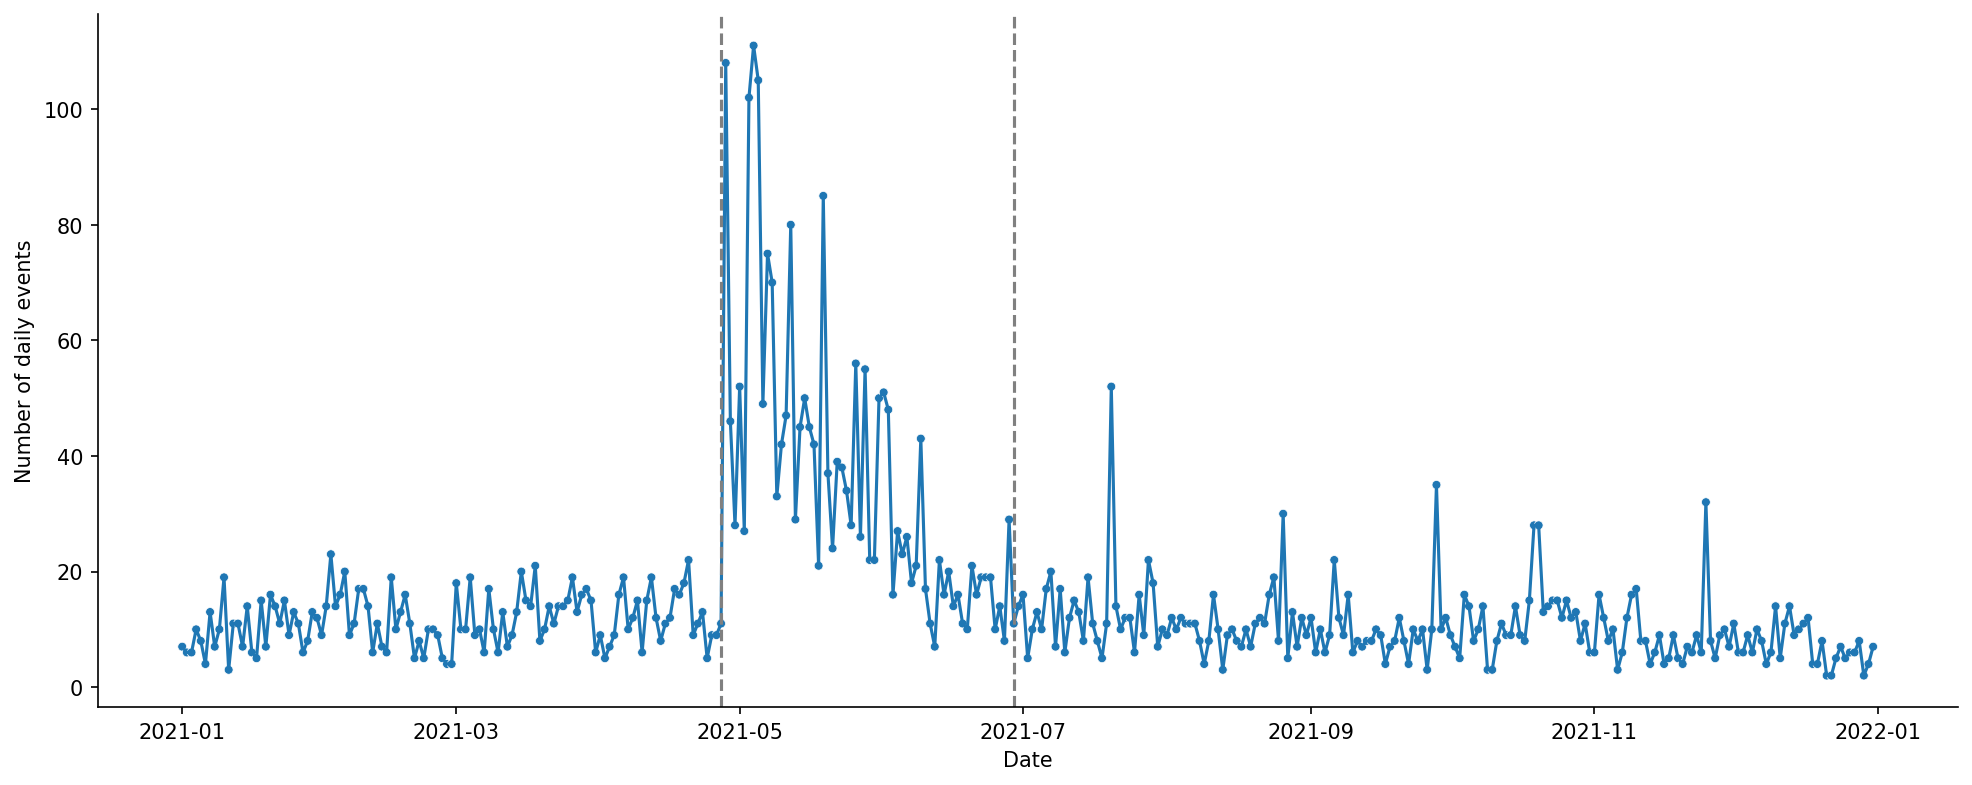

In [23]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 150)
sns.despine()
sns.lineplot(data = eventos_diarios, x = "event_date", y = "n", ax = ax)
sns.scatterplot(data = eventos_diarios, x = "event_date", y = "n", size = 1, legend = False, ax = ax)
plt.xlabel("Date")
plt.ylabel("Number of daily events")
# plt.title("Número de eventos diarios");

ax.axvline(pd.to_datetime('2021-04-27'), linestyle='--', color = 'grey')
ax.axvline(pd.to_datetime('2021-06-29'), linestyle='--', color = 'grey')
plt.savefig("../../Results/Presentacion Trees/ACLED/Number of Daily Events.png")

In [24]:
serie_disorder_type = acled[["event_id_cnty", "event_date", "disorder_type"]].drop_duplicates().reset_index(drop = True)
# Tenemos entradas como "Political violence; Demonstrations". Queremos partir en dos estos eventos
s = serie_disorder_type['disorder_type'].str.split('; ', expand=True).stack()
s.index = s.index.droplevel(-1)  
s.name = 'disorder_type'  
# Eliminamos la columna original para cambiarla por la nueva
del serie_disorder_type['disorder_type']
# Se pega la columna nueva en la base original
serie_disorder_type = serie_disorder_type.join(s)
serie_disorder_type = serie_disorder_type.reset_index(drop=True)
# Contamos ocurrencias
serie_disorder_type = serie_disorder_type.groupby(["event_date", "disorder_type"]).size().reset_index(name = "n")
# Filtramos fechas
serie_disorder_type = serie_disorder_type.loc[serie_disorder_type["event_date"].dt.year == 2021]

In [25]:
serie_event_type = acled[["event_id_cnty", "event_date", "event_type"]].drop_duplicates() \
    .groupby(["event_date", "event_type"]).size().reset_index(name = "n")
# Filtramos fechas
serie_event_type = serie_event_type.loc[serie_event_type["event_date"].dt.year == 2021]

serie_sub_event_type = acled[["event_id_cnty", "event_date", "sub_event_type"]].drop_duplicates() \
    .groupby(["event_date", "sub_event_type"]).size().reset_index(name = "n")
# Filtramos fechas
serie_sub_event_type = serie_sub_event_type.loc[serie_sub_event_type["event_date"].dt.year == 2021]

In [26]:
eventos_diarios.to_pickle("/mnt/disk2/Data/eventos_diarios.gzip", compression='gzip')
serie_sub_event_type.to_pickle("/mnt/disk2/Data/eventos_diarios.gzip", compression='gzip')
serie_event_type.to_pickle("/mnt/disk2/Data/eventos_diarios.gzip", compression='gzip')
serie_disorder_type.to_pickle("/mnt/disk2/Data/eventos_diarios.gzip", compression='gzip')

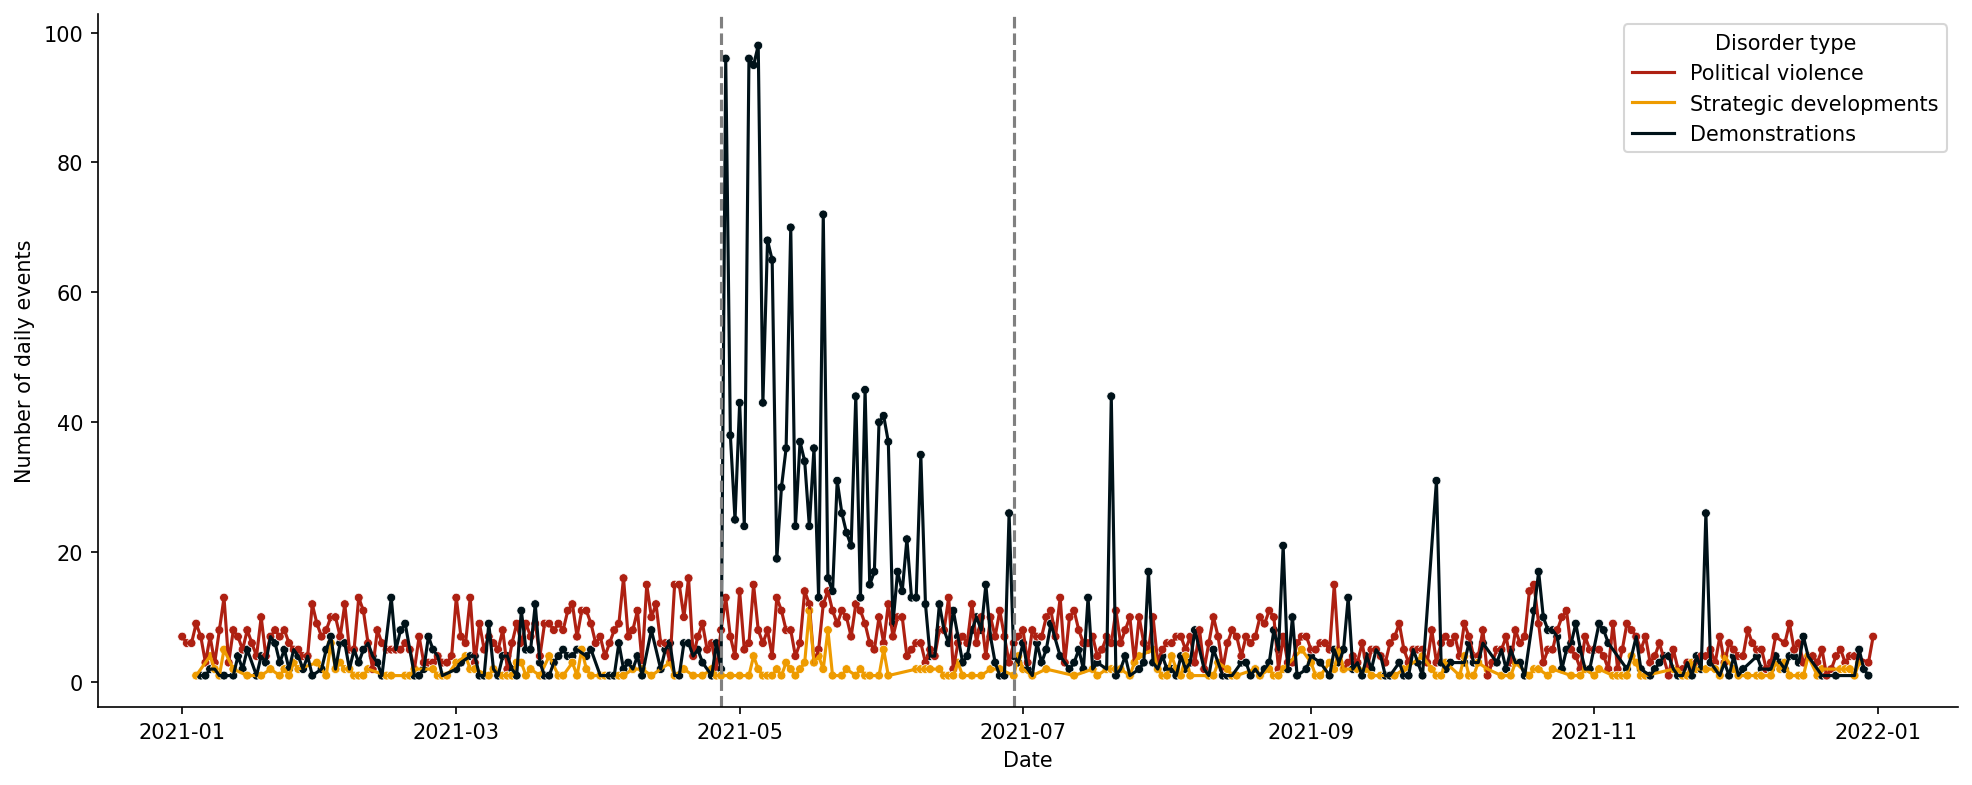

In [36]:
palette = ["#ae2012", "#ee9b00", "#001219"]

fig, ax = plt.subplots(figsize = (16, 6), dpi = 150)
sns.despine()
sns.lineplot(data = serie_disorder_type, x = "event_date", y = "n", hue = "disorder_type", palette = palette, ax = ax)
sns.scatterplot(data = serie_disorder_type, x = "event_date", y = "n", hue = "disorder_type", palette = palette, 
                legend = False, size = 1, ax = ax)
plt.xlabel("Date")
plt.ylabel("Number of daily events")
# plt.title("Número de eventos diarios por Tipo de Disturbio");
plt.legend(title = "Disorder type");

ax.axvline(pd.to_datetime('2021-04-27'), linestyle='--', color = 'grey')
ax.axvline(pd.to_datetime('2021-06-29'), linestyle='--', color = 'grey')
plt.savefig("../../Results/Presentacion Trees/ACLED/Number of Daily Events by Disorder Type.png")

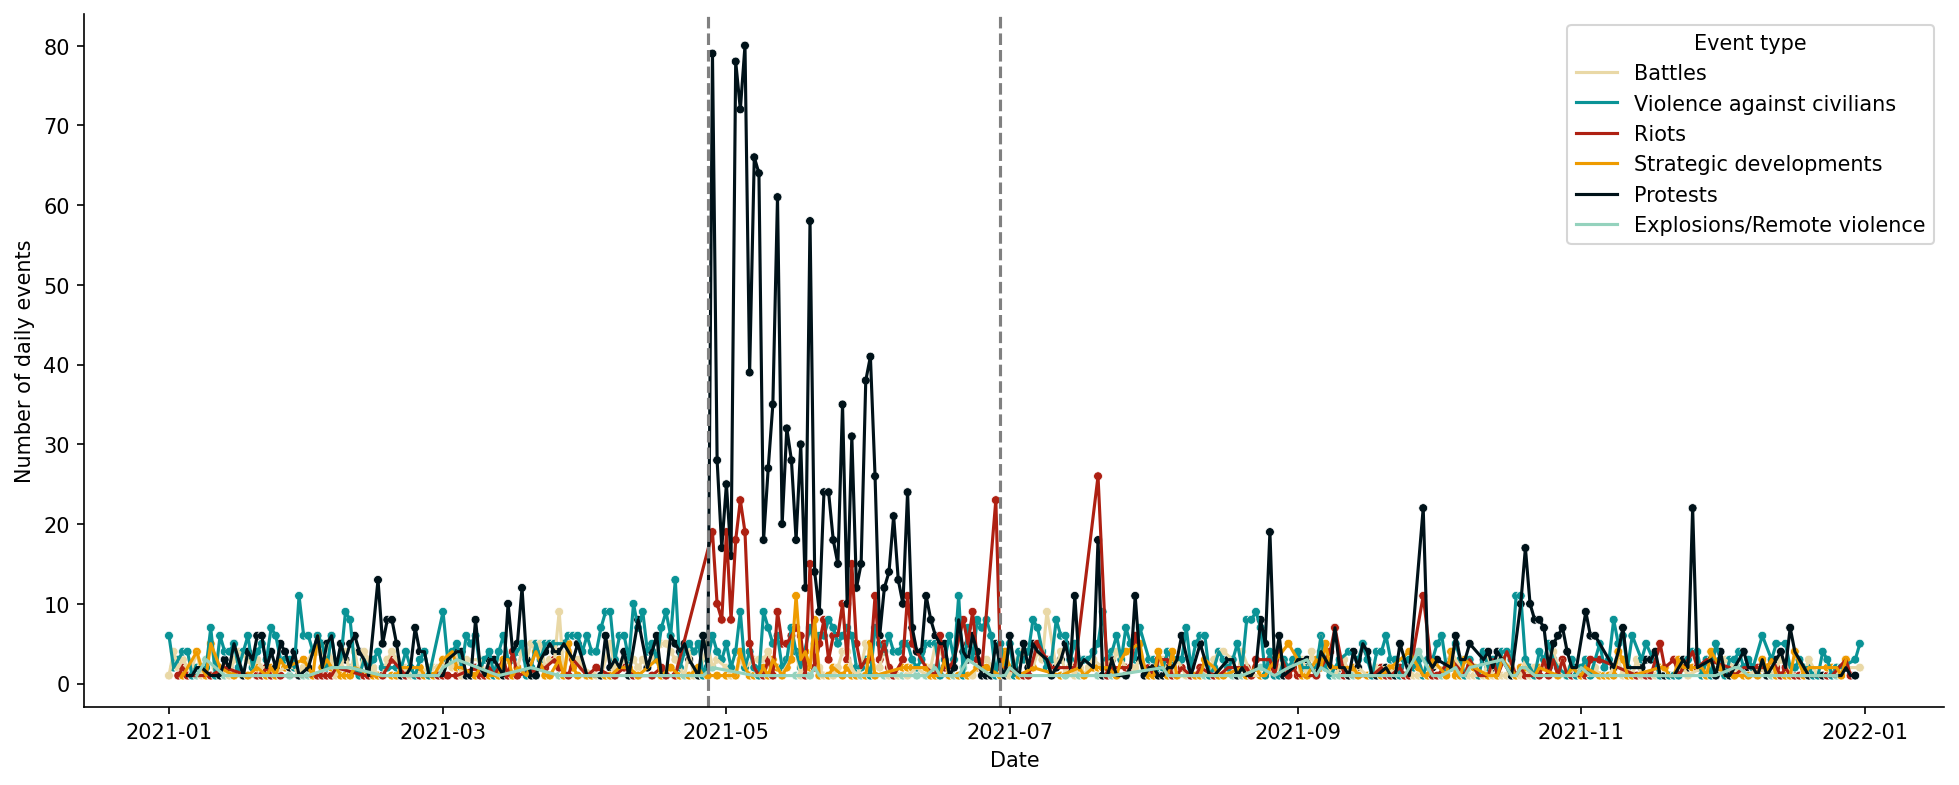

In [38]:
palette = ["#e9d8a6", "#0a9396", "#ae2012", "#ee9b00", "#001219", "#94d2bd"]

fig, ax = plt.subplots(figsize = (16, 6), dpi = 150)
sns.despine()
sns.lineplot(data = serie_event_type, x = "event_date", y = "n", hue = "event_type", palette = palette, ax = ax)
sns.scatterplot(data = serie_event_type, x = "event_date", y = "n", hue = "event_type", palette = palette,
                legend = False, size = 1, ax = ax)
plt.xlabel("Date")
plt.ylabel("Number of daily events")
plt.legend(title = "Event type");

ax.axvline(pd.to_datetime('2021-04-27'), linestyle='--', color = 'grey')
ax.axvline(pd.to_datetime('2021-06-29'), linestyle='--', color = 'grey')
plt.savefig("../../Results/Presentacion Trees/ACLED/Number of Daily Events by Event Type.png")

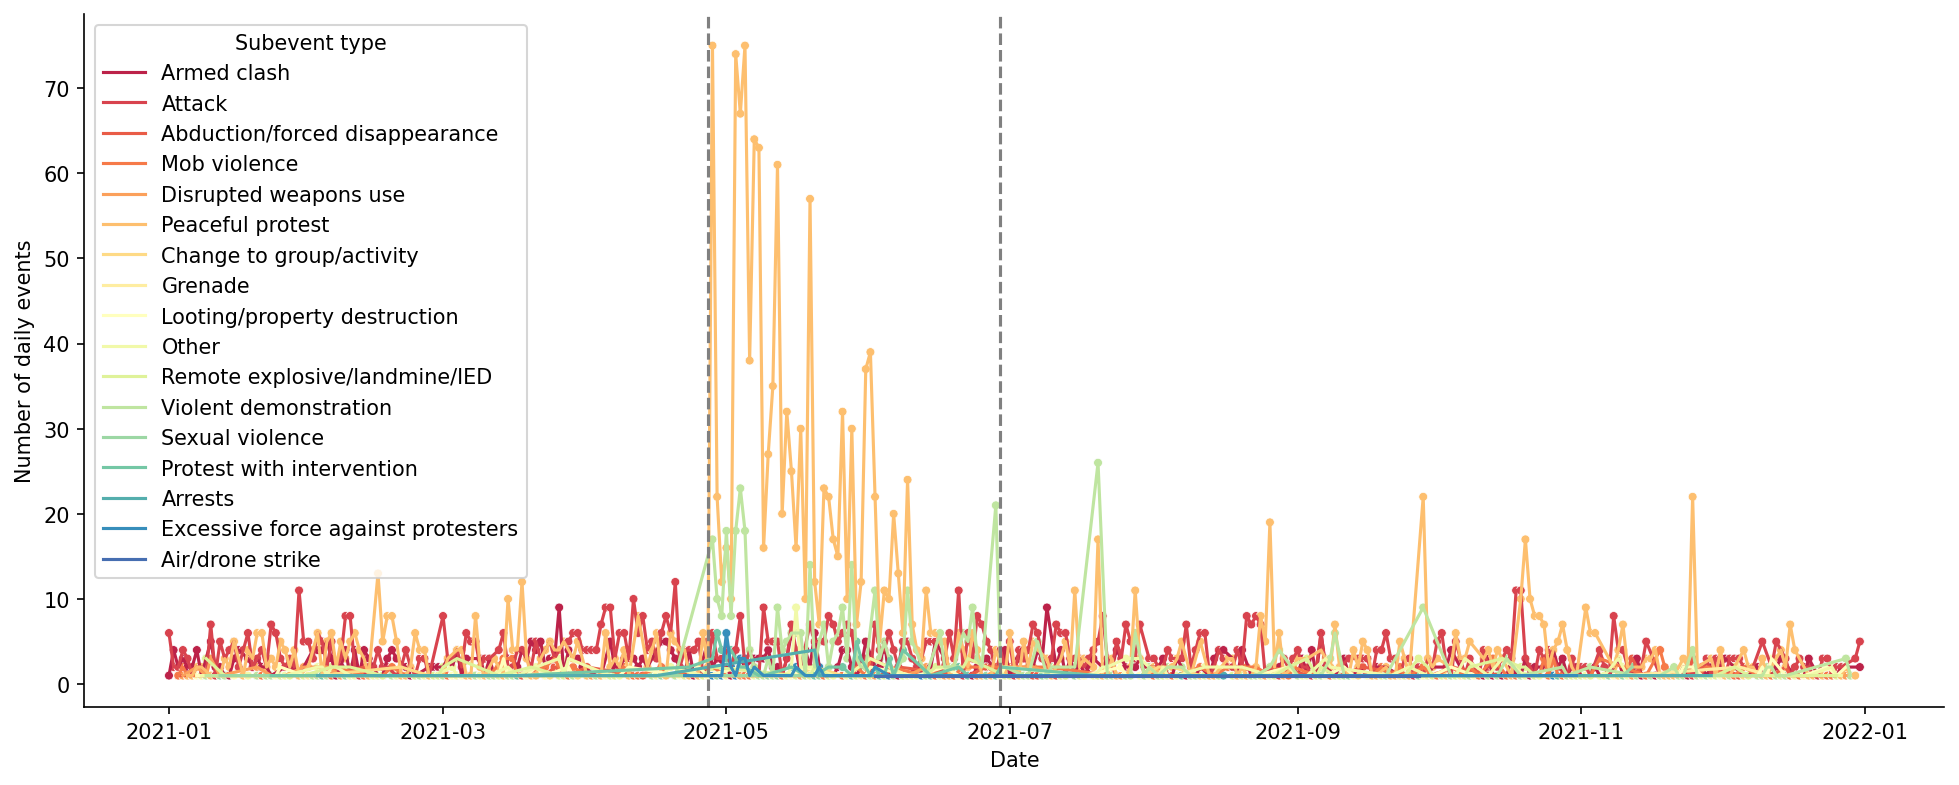

In [39]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 150)
sns.despine()
sns.lineplot(data = serie_sub_event_type, x = "event_date", y = "n", hue = "sub_event_type", palette = "Spectral", ax = ax)
sns.scatterplot(data = serie_sub_event_type, x = "event_date", y = "n", hue = "sub_event_type", palette = "Spectral",
                legend = False, size = 1, ax = ax)
plt.xlabel("Date")
plt.ylabel("Number of daily events")
plt.legend(title = "Subevent type");

ax.axvline(pd.to_datetime('2021-04-27'), linestyle='--', color = 'grey')
ax.axvline(pd.to_datetime('2021-06-29'), linestyle='--', color = 'grey')
plt.savefig("../../Results/Presentacion Trees/ACLED/Number of Daily Events by Subevent Type.png")

### Policía vs Civiles

In [40]:
filtro = acled["interaction"].isin(["STATE FORCES VERSUS RIOTERS", "STATE FORCES VERSUS PROTESTERS", "STATE FORCES VERSUS CIVILIANS"])
serie_policia_civiles = acled.loc[filtro, ["event_id_cnty", "event_date", "interaction"]].drop_duplicates()
serie_policia_civiles = serie_policia_civiles.groupby(["event_date", "interaction"]).size().reset_index(name = "n")
# Filtramos fechas
serie_policia_civiles = serie_policia_civiles.loc[serie_policia_civiles["event_date"].dt.year == 2021]
eventos_diarios["interaction"] = "TOTAL"
serie_policia_civiles = pd.concat([serie_policia_civiles, eventos_diarios], axis = 0)

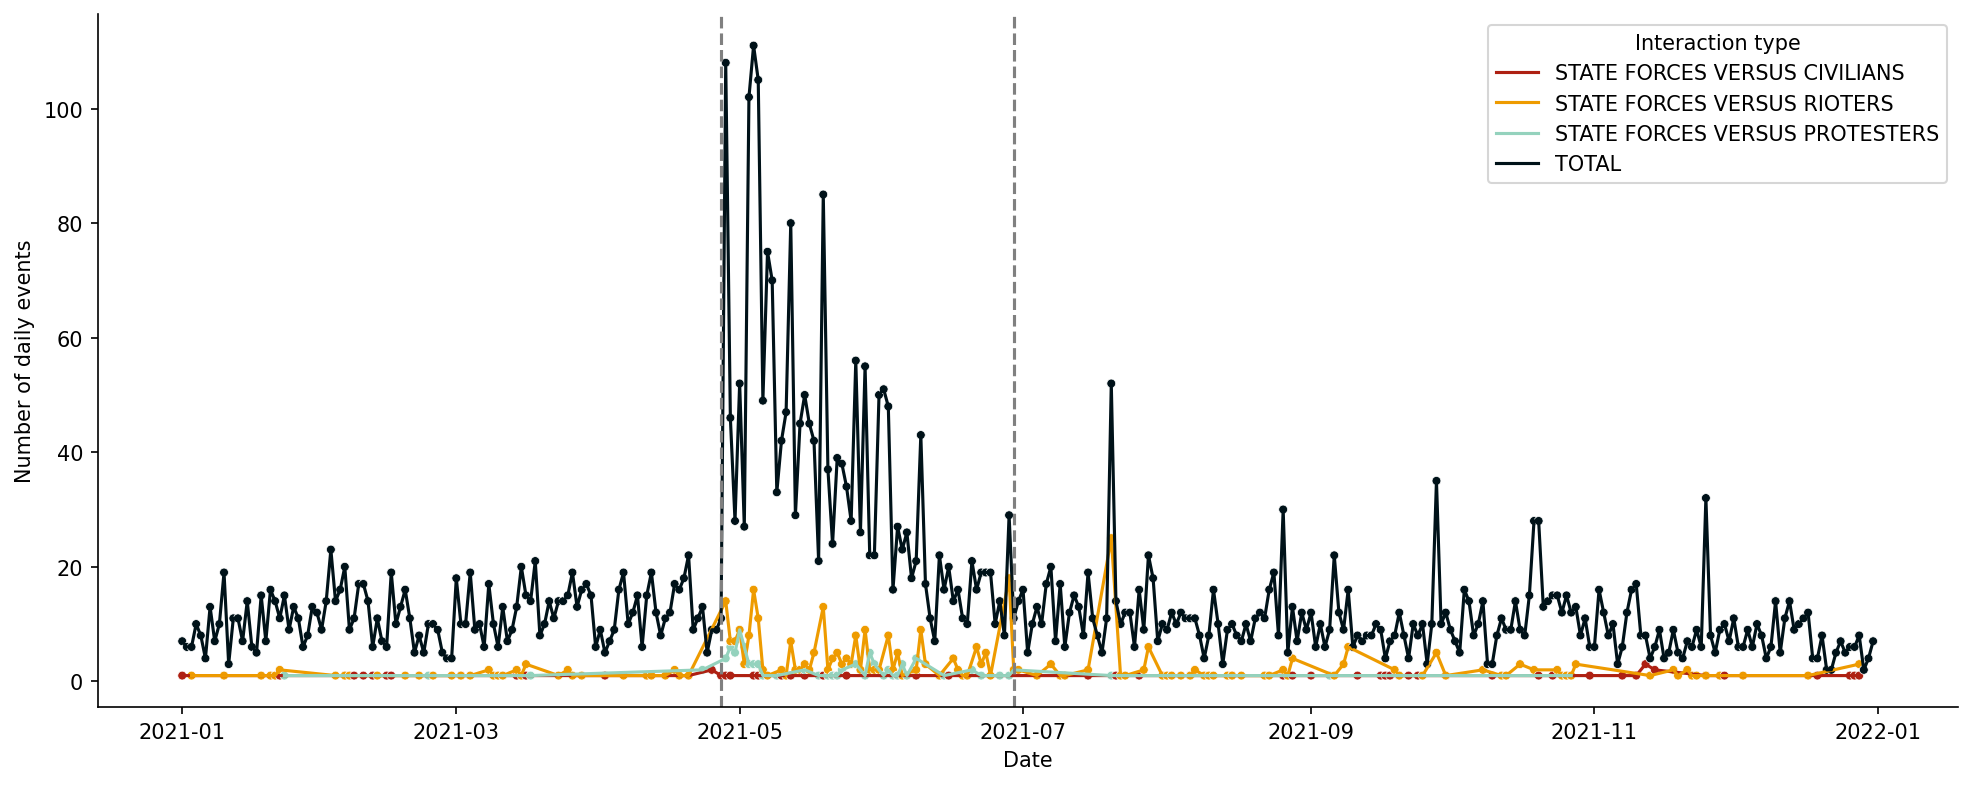

In [41]:
palette = ["#ae2012", "#ee9b00", "#94d2bd", "#001219"]

fig, ax = plt.subplots(figsize = (16, 6), dpi = 150)
sns.despine()
sns.lineplot(data = serie_policia_civiles, x = "event_date", y = "n", hue = "interaction", palette = palette, ax = ax)
sns.scatterplot(data = serie_policia_civiles, x = "event_date", y = "n", hue = "interaction", palette = palette,
                legend = False, size = 1, ax = ax)
plt.xlabel("Date")
plt.ylabel("Number of daily events")
plt.legend(title = "Interaction type");

ax.axvline(pd.to_datetime('2021-04-27'), linestyle='--', color = 'grey')
ax.axvline(pd.to_datetime('2021-06-29'), linestyle='--', color = 'grey')
plt.savefig("../../Results/Presentacion Trees/ACLED/Number of Daily Events by Interaction Type.png")

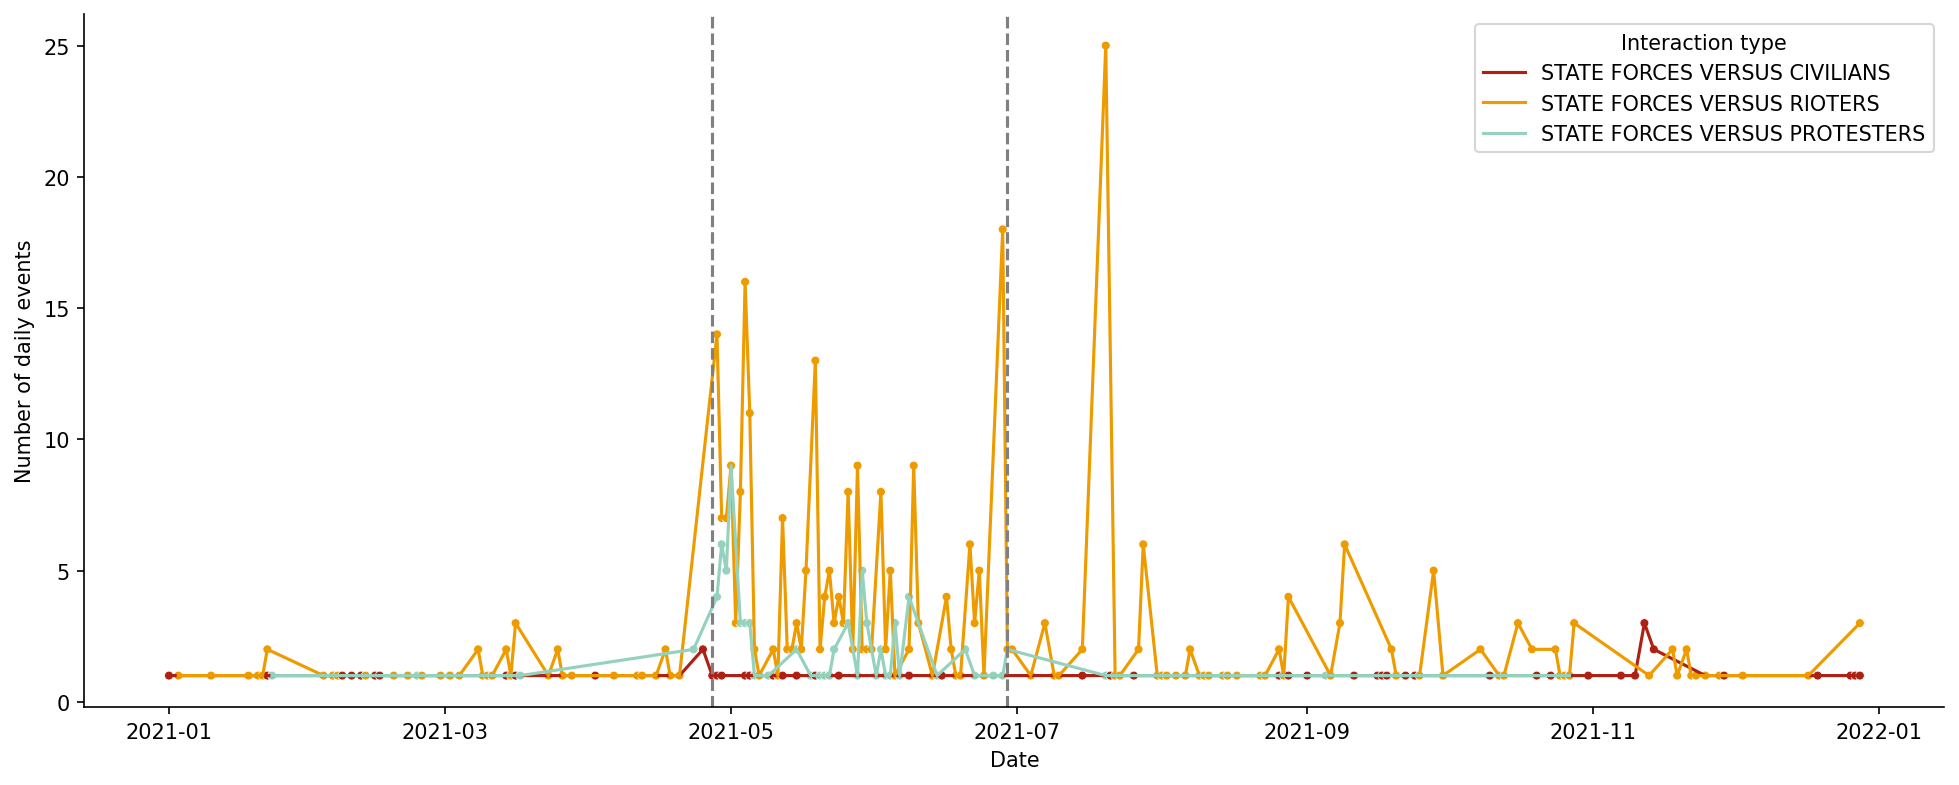

In [42]:
palette = ["#ae2012", "#ee9b00", "#94d2bd"]

fig, ax = plt.subplots(figsize = (16, 6), dpi = 150)
sns.despine()
sns.lineplot(data = serie_policia_civiles.query("interaction != 'TOTAL'"), x = "event_date", y = "n", hue = "interaction", palette = palette, ax = ax)
sns.scatterplot(data = serie_policia_civiles.query("interaction != 'TOTAL'"), x = "event_date", y = "n", hue = "interaction", palette = palette,
                legend = False, size = 1, ax = ax)
plt.xlabel("Date")
plt.ylabel("Number of daily events")
plt.legend(title = "Interaction type");

ax.axvline(pd.to_datetime('2021-04-27'), linestyle='--', color = 'grey')
ax.axvline(pd.to_datetime('2021-06-29'), linestyle='--', color = 'grey')
plt.savefig("../../Results/Presentacion Trees/ACLED/Number of Daily Events by Interaction Type (without Total).png")

### Número de personas involucradas

In [43]:
acled["tags"] = acled["tags"].apply(lambda x: re.sub(r',', '', str(x)))
# Remove spaces between numbers
acled["tags"] = acled["tags"].apply(lambda x: re.sub(r'(?<=\d) (?=\d)', '', x))
acled["tags"] = acled["tags"].str.replace("hundreds", "100")

acled["crowd_size"] = acled["tags"].apply(lambda x: re.search("(\d+)", x).group(1) if re.search("(\d+)", x) else None)
acled["crowd_size"] = pd.to_numeric(acled["crowd_size"])
acled["crowd_size"].describe()

count      1678.000000
mean       1043.194875
std        4731.310701
min           1.000000
25%          40.000000
50%         100.000000
75%         300.000000
max      100000.000000
Name: crowd_size, dtype: float64

In [44]:
serie_disorder_type2 = acled[["event_id_cnty", "event_date", "disorder_type", "crowd_size"]].drop_duplicates().reset_index(drop = True)
# Tenemos entradas como "Political violence; Demonstrations". Queremos partir en dos estos eventos
s = serie_disorder_type2['disorder_type'].str.split('; ', expand=True).stack()
s.index = s.index.droplevel(-1)  
s.name = 'disorder_type'  
# Eliminamos la columna original para cambiarla por la nueva
del serie_disorder_type2['disorder_type']
# Se pega la columna nueva en la base original
serie_disorder_type2 = serie_disorder_type2.join(s)
serie_disorder_type2 = serie_disorder_type2.reset_index(drop=True)
# Contamos ocurrencias
serie_disorder_type2 = serie_disorder_type2.groupby(["event_date", "disorder_type"])["crowd_size"].sum().reset_index(name = "n")
# Filtramos fechas
serie_disorder_type2 = serie_disorder_type2.loc[serie_disorder_type2["event_date"].dt.year == 2021]

In [45]:
serie_disorder_type2.sort_values('n', ascending=False).head()

,event_date,disorder_type,n
2728,2021-05-28,Demonstrations,60710.0
2650,2021-05-01,Demonstrations,53600.0
2825,2021-07-04,Demonstrations,30200.0
2653,2021-05-02,Demonstrations,24430.0
2703,2021-05-19,Demonstrations,21680.0


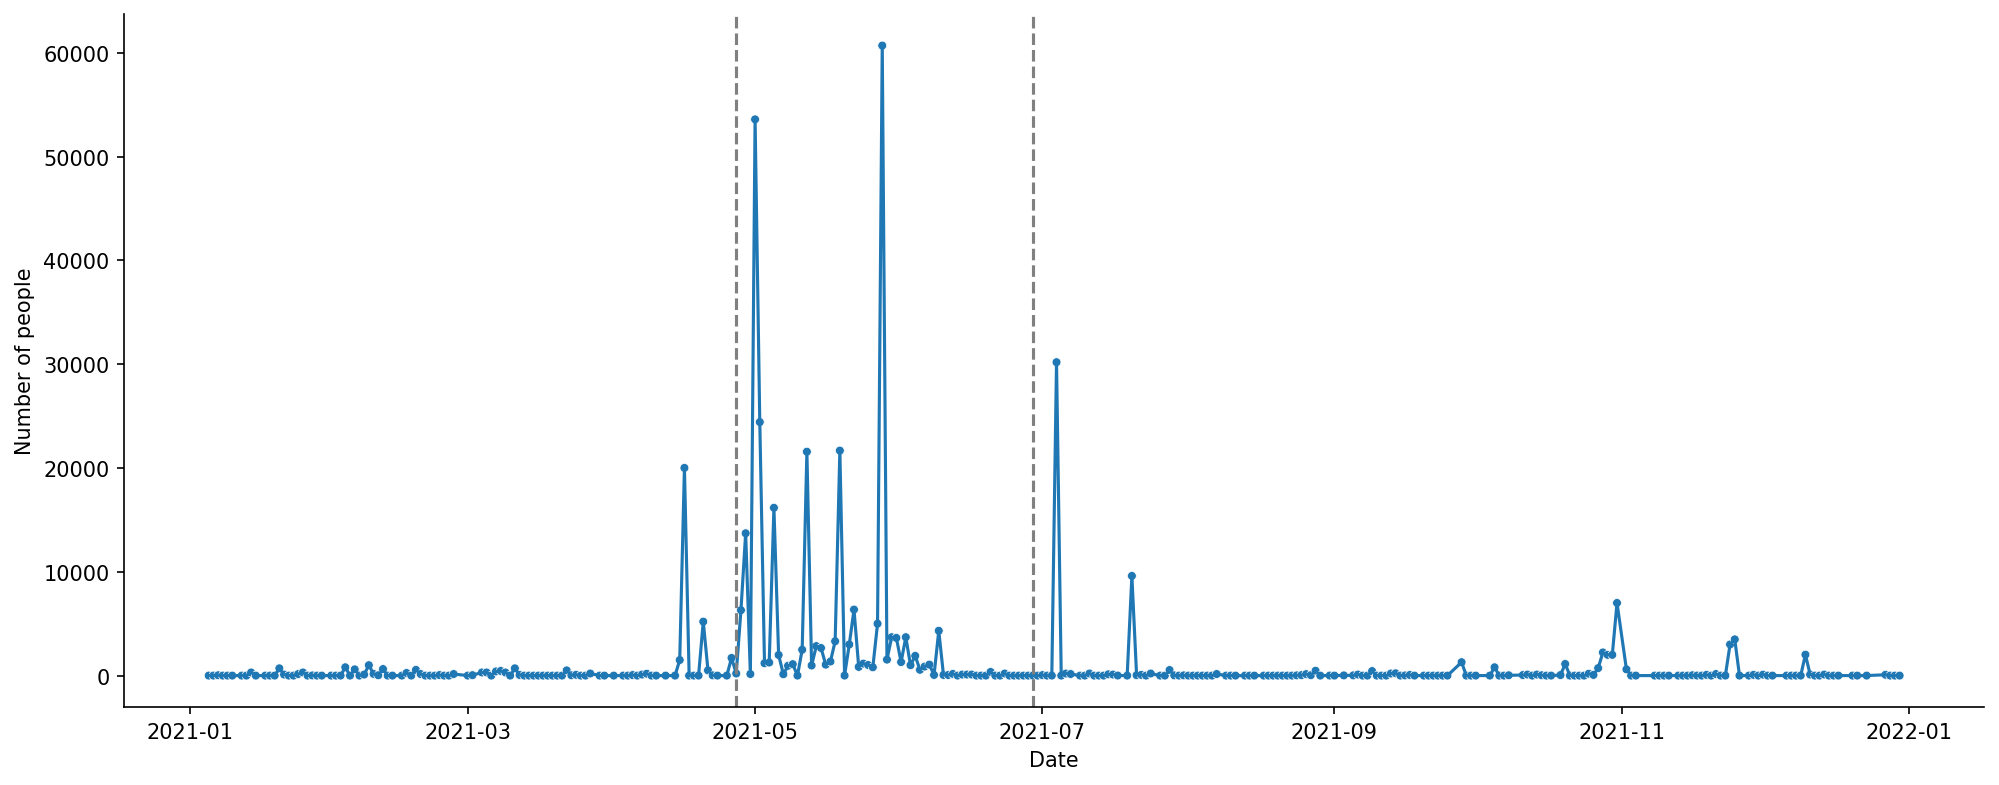

In [47]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 150)
sns.despine()
sns.lineplot(data = serie_disorder_type2.query("disorder_type == 'Demonstrations'"), x = "event_date", y = "n", ax = ax)
sns.scatterplot(data = serie_disorder_type2.query("disorder_type == 'Demonstrations'"), x = "event_date", y = "n",
                legend = False, size = 1, ax = ax)
plt.xlabel("Date")
plt.ylabel("Number of people")

ax.axvline(pd.to_datetime('2021-04-27'), linestyle='--', color = 'grey')
ax.axvline(pd.to_datetime('2021-06-29'), linestyle='--', color = 'grey')
plt.savefig("../../Results/Presentacion Trees/ACLED/Estimated number of protesters.png")